# [ICM Development](@id Development)

The model from [Saiz et al.](https://elifesciences.org/articles/56079) has three parts in the model

## Definition of the model

### Mechanics

The cells are spheroids that behave under the following equations:

$$m_i\frac{dv_i}{dt} =-bv_i+\sum_j F_{ij}$$

$$\frac{dx_i}{dt} =v_i$$

where the force is

$$F_{ij}=
\begin{cases}
F_0(\frac{r_{ij}}{d_{ij}}-1)(\frac{\mu r_{ij}}{d_{ij}}-1)\frac{(x_i-x_j)}{d_{ij}}\hspace{1cm}if\;d_{ij}<\mu r_{ij}\\
0\hspace{5cm}otherwise
\end{cases}$$

where $d_{ij}$ is the Euclidean distance and $r_{ij}$ is the sum of both radius.

### Biochemical interaction

Each cell has a biochemical component that follows an equation of the form:

$$\frac{dx_i}{dt}=\frac{α(1+x^n_i)^m}{(1+x^n_i)^m+(1+(\langle x\rangle_i)/K)^{2m}}-x_i$$

This is similar to the above case. The only detail required is to note that the average expression can be modeled as the combination of two interacting variables. The biochemical system is activated in the interval $[t_{on},t_{off}]$.

We made explicit that the average operator can be written as two interaction parameters that are the contraction along the second index that runs over the neighbours of each cell as,

$$N_{ij}=
\begin{cases}
1\hspace{1cm}d<f_{range}r_{ij}\\
0\hspace{1cm}otherwise
\end{cases}$$

$$X_{ij}=
\begin{cases}
x_j\hspace{1cm}d<f_{range}r_{ij}\\
0\hspace{1cm}otherwise
\end{cases}$$

$$\langle x\rangle_i=\frac{\sum_j X_{ij}}{\sum_j N_{ij}}=\frac{X_{i}}{N_{i}}$$

### Growth

The cells present division. The rules for the division in this model are. Random election of a division direction over the unit sphere. The daughter cells divide equally in mass and volume and are positioned in oposite directions around the division axis centered at the parent cell. The chemical concentration is divided asymmetrically with each cell taking $1\pm\sigma_x \text{Uniform}(0,1)$ for the parent cell. A new division time is assigned to each aghter cell from a uniform distribution $\text{Uniform}(\tau_{div}(1-\sigma_{div}),\tau_{div}(1+\sigma_{div}))$.

## Creation of the Agent

In [1]:
#Package
using CellBasedModels
#Functions for generating random distributions
using Random
using Distributions
#Package for plotting in 3D
using GLMakie
Makie.inline!(true)

using CSV
using DataFrames

[ Info: Precompiling CellBasedModels [388cb286-f2b1-4654-a3bb-2e137a39c658]
  ** incremental compilation may be fatally broken for this module **

  ** incremental compilation may be fatally broken for this module **



### Define the agent

First, we have to create an instance of an agent with all the propoerties of the agents.First, we have to create an instance of an agent with all the propoerties of the agents.

In [3]:
model = ABM(3,

    #Inherit model mechanics
    baseModelInit = [CBMModels.softSpheres3D],

    #Global parameters
    model = Dict(
        #Chemical constants
        :α=>Float64, 
        :K=>Float64, 
        :nn=>Float64, 
        :mm=>Float64,
        #Physical constants
        :fRange=>Float64, 
        :mi=>Float64, 
        :ri=>Float64, 
        :k0=>Float64,
        #Division constants
        :fAdh=>Float64, 
        :τDiv=>Float64, 
        :σDiv=>Float64, 
        :c0=>Float64, 
        :σc=>Float64, 
        :nCirc=>Float64, 
        :σNCirc=>Float64,
        :fMin=>Float64, 
        :fMax=>Float64, 
        :fPrE=>Float64, 
        :fEPI=>Float64, 
        :τCirc=>Float64, 
        :στCirc=>Float64, 
        :rESC=>Float64,
        :nOn=>Float64, 
        :cMax=>Float64
    ),
    #Local float parameters
    agent = Dict(
        :c=>Float64,
        :tDivision=>Float64, #Variable storing the time of division of the cell
        :ci=>Float64, #Chemical activity of the neighbors
        :ni=>Float64,  #Number of neighbors
        :tOff=>Bool,    #indicate if the circuit for that cell is on or off (0,1)
        :cellFate=>Int64 #Identity of the cell (1 DP, 2 EPI, 3 PRE)
    ),
    #Chemical dynamics
    agentODE = quote

        ni = 0
        ci = 0
        @loopOverNeighbors it2 begin
            dij = CBMMetrics.euclidean(x,x[it2],y,y[it2],z,z[it2])
            rij = r+r[it2]
            if dij < fRange*rij
                ni += 1
                ci += c[it2]
            end
        end

        if tOff == false && N > nOn #Activate circuit
            dt( c ) = α*(1+c^nn)^mm/((1+c^nn)^mm+(1+(ci/ni)/K)^(2*mm)) - c
        end

    end,
    #Interaction computation
    agentRule=quote
        #Circuit deactivation and commitment
        if c < fPrE*cMax && tOff == false && N > nOn
            cellFate = 3
        elseif c > fEPI*cMax && tOff == false && N > nOn
            cellFate = 2
        end

        if c < fMin*cMax && tOff == false && N > nOn
            tOff = true
        elseif c > fMax*cMax && tOff == false && N > nOn
            tOff = true
        end

        #Growth
        if t > tDivision
            #Choose random direction in unit sphere
            xₐ = CBMDistributions.normal(0,1); yₐ = CBMDistributions.normal(0,1); zₐ = CBMDistributions.normal(0,1)
            Tₐ = sqrt(xₐ^2+yₐ^2+zₐ^2)
            xₐ /= Tₐ;yₐ /= Tₐ;zₐ /= Tₐ    

            #Chose a random distribution of the material
            dist = CBMDistributions.uniform(1-σc,1+σc)

            rsep = r/2
            rnew = r/(2. ^(1. /3))
            @addAgent( #Add new agent
                x = x+rsep*xₐ,
                y = y+rsep*yₐ,
                z = z+rsep*zₐ,
                vx = 0,
                vy = 0,
                vz = 0,
                r = rnew,
                m = m/2,
                c = c*(dist),
                tDivision = t + CBMDistributions.uniform(τDiv*(1-σDiv),τDiv*(1+σDiv))
            )
            @addAgent( #Add new agent
                x = x-rsep*xₐ,
                y = y-rsep*yₐ,
                z = z-rsep*zₐ,
                vx = 0,
                vy = 0,
                vz = 0,
                r = rnew,
                m = m/2,
                c = c*(2-dist),
                tDivision = t + CBMDistributions.uniform(τDiv*(1-σDiv),τDiv*(1+σDiv))
            )
            @removeAgent() # Remove agent that divided
            
        end
    end
);

## Community construction and initialisation

Once with the model created, we have to construct an initial Community of agents to evolve.

### Parameters

The model from the original version has some parameters defined. We create a dictionary with all the parameters from the model assigned.

In [4]:
parameters = Dict([
    :α => 10,
    :K => .9,
    :nn => 2,
    :mm => 2,
    :fRange => 1.2,
    :mi => 10E-6,
    :ri => 5,
    :b => 10E-6,
    :k0 => 10E-4,
    :fAdh => 1.5,
    :μ => 2,
    :τDiv => 10,
    :σDiv => .5,
    :c0 => 3,
    :σc => 0.01,
    :nCirc => 20,
    :σNCirc => .1,
    :fMin => .05,
    :fMax => .95,
    :fPrE => .2,
    :fEPI => .8,
    :τCirc => 45.,
    :στCirc => .02,
    :rESC => 2,
    :f0 => [1 1 1;1 1 1;1 1 1]
]);

### Initialise the community

The model starts from just one agent. Create the community and assign all the parameters to the Community object.

In [5]:
function initializeEmbryo(parameters;dt)

    com = Community(
                model,
                N=1,
                dt=dt,
                agentAlg=CBMIntegrators.Heun()
                )

    #Global parameters
    for (par,val) in pairs(parameters)
        com[par] = val
    end

    com.nOn = rand(Uniform(parameters[:nCirc]-parameters[:σNCirc],parameters[:nCirc]+parameters[:σNCirc]))
    com.cMax = parameters[:α]/(1+1/(2*parameters[:K])^(2*parameters[:mm]))

    #########Local parameters and variables###########
    com.f0 = parameters[:k0].*parameters[:f0]# / parameters[:fAdh]
    #Initialise locals
    com.m = parameters[:mi]
    com.r = parameters[:ri]
    com.cellFate = 1 #Start neutral fate
    com.tOff = false #Start with the tOff deactivated
    #Initialise variables
    com.x = 0.
    com.y = 0.
    com.z = 0.
    com.vx = 0.
    com.vy = 0.
    com.vz = 0.
    com.c = com.c0
    com.tDivision = 1#rand(Uniform(com.τDiv-com.σDiv,com.τDiv+com.σDiv))

    return com

end;

In [6]:
com = initializeEmbryo(parameters,dt=0.001);

## Creating a custom evolve step

In [7]:
function customEvolve!(com,steps,saveEach)
    loadToPlatform!(com,preallocateAgents = 100)
    for i in 1:steps
        agentStepDE!(com)
        agentStepRule!(com)
        update!(com)
        computeNeighbors!(com)
        if i % saveEach == 0
            saveRAM!(com)
        end
        #Stop by time
        if all(com.N .> 60)
            break
        end
        #println(com.c[1:com.N])
    end
    bringFromPlatform!(com)
end;

In [8]:
dt = 0.001
steps = round(Int64,50/dt)
saveEach = round(Int64,.5/dt)

com = initializeEmbryo(parameters,dt=dt);
customEvolve!(com,steps,saveEach)

### Visualization of results

We check how the agents starts to divide and choose a fate at late stages of the simulation.

In [9]:
function getFates(com)
    d = getParameter(com,[:t,:cellFate])

    dict = Dict()
    dict["t"] = [i[1] for i in d[:t]]
    dict["N"] = [length(i) for i in d[:cellFate]]
    for (fateNumber, fate) in zip([1,2,3],["DP","EPI","PRE"])
        dict[fate] = [sum(i.==fateNumber) for i in d[:cellFate]] 
    end

    return dict
end;

In [10]:
colorMap = Dict("DP"=>Makie.wong_colors()[1],"EPI"=>Makie.wong_colors()[2],"PRE"=>Makie.wong_colors()[3])
colorMapNum = Dict(1=>Makie.wong_colors()[1],2=>Makie.wong_colors()[2],3=>Makie.wong_colors()[3]);

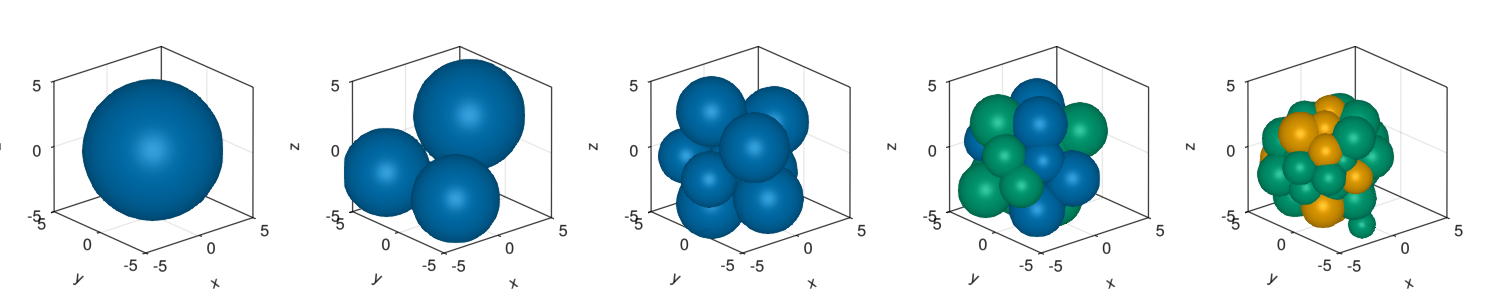

In [11]:
fig = Figure(resolution=(1500,300))

d = getParameter(com,[:x,:y,:z,:r,:cellFate])
for (i,pos) in enumerate([1:round(Int64,length(com)/4):length(com);length(com)])
    ax = Axis3(fig[1,i],aspect = :data)
    color = [colorMapNum[i] for i in d[:cellFate][pos]]
    meshscatter!(ax,d[:x][pos],d[:y][pos],d[:z][pos],markersize=d[:r][pos],color=color)
    xlims!(ax,-5,5)
    ylims!(ax,-5,5)
    zlims!(ax,-5,5)
end

display(fig)

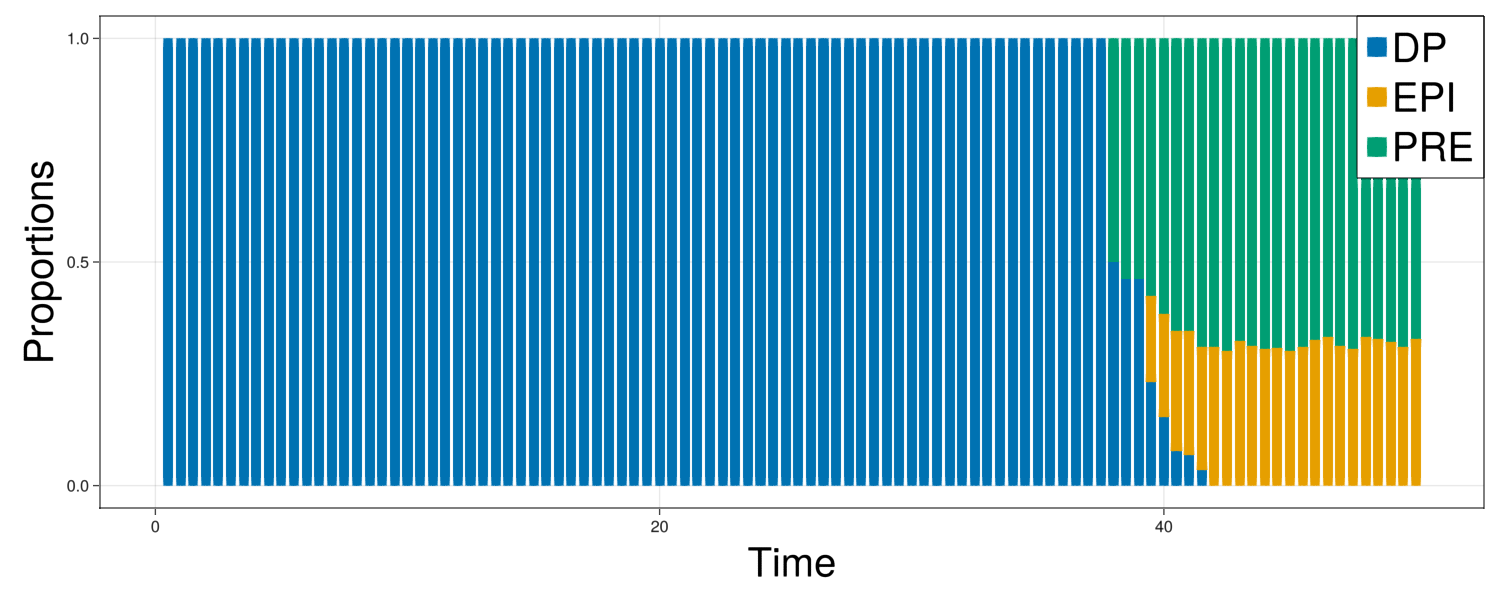

In [12]:
fig = Figure(resolution=(1500,600))

ax = Axis(fig[1,1],xlabel="Time",ylabel="Proportions",xlabelsize=40,ylabelsize=40)
fates = getFates(com)
offset = zeros(length(fates["N"]))
plots = []
for i in ["DP","EPI","PRE"]
    prop = fates[i]./fates["N"]
    p = barplot!(ax,fates["t"],prop,offset=offset,color=colorMap[i])
    push!(plots,p)
    offset .+= prop
end
Legend(fig[1,1], plots, ["DP","EPI","PRE"], halign = :right, valign = :top, tellheight = false, tellwidth = false, labelsize=40)

display(fig)

### Make statistics of the model

This model contains stochasticity in the division times and the concentration of chemical components that the daughter agents receive. This will make different runs of the simulation to differ. In order to make statistics we run the model several times and collect information of the size and fates of the cells.

In [13]:
function makeStatistics(comBase,parameters,dt,steps,saveEach,nRepetitions)

    #Make simulations and add results to list
    d = Dict("id"=>Int64[],"N"=>Int64[],"t"=>Float64[],"DP"=>Int64[],"EPI"=>Int64[],"PRE"=>Int64[])
    for i in 1:nRepetitions
        #Make the simulations
        com = initializeEmbryo(parameters,dt=dt);
        setfield!(com,:abm,comBase.abm) #Avoid world problem assigning the functions of globally declared function model
        customEvolve!(com,steps,saveEach)
    
        #Add them to the model
        fates = getFates(com)
        append!(d["id"],i*ones(Int64,length(fates["N"])))
        append!(d["N"],fates["N"])
        append!(d["t"],fates["t"])
        append!(d["DP"],fates["DP"])
        append!(d["EPI"],fates["EPI"])
        append!(d["PRE"],fates["PRE"])
    end

    return d
end;

In [14]:
dt = 0.001
steps = round(Int64,50/dt)
saveEach = round(Int64,1/dt)
nRepetitions = 5

prop = makeStatistics(com,parameters,dt,steps,saveEach,nRepetitions);

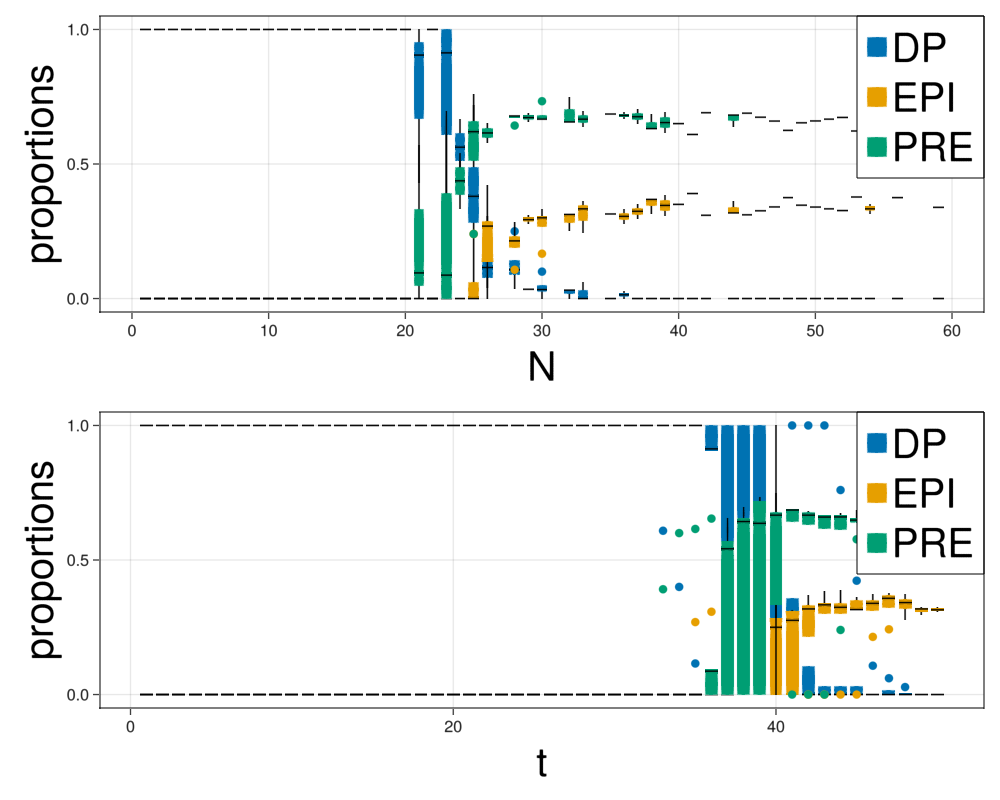

In [15]:
fig = Figure(resolution=(1000,800))

ax = Axis(fig[1,1],xlabel="N",xlabelsize=40,ylabel="proportions",ylabelsize=40)
for i in ["DP","EPI","PRE"]
    boxplot!(ax,prop["N"],prop[i]./prop["N"],color=colorMap[i])
end
Legend(fig[1,1], plots, ["DP","EPI","PRE"], halign = :right, valign = :top, tellheight = false, tellwidth = false, labelsize=40)

ax = Axis(fig[2,1],xlabel="t",xlabelsize=40,ylabel="proportions",ylabelsize=40)
for i in ["DP","EPI","PRE"]
    boxplot!(ax,prop["t"],prop[i]./prop["N"],color=colorMap[i])
end
Legend(fig[2,1], plots, ["DP","EPI","PRE"], halign = :right, valign = :top, tellheight = false, tellwidth = false, labelsize=40)

display(fig)

## Fitting the model

The parameters above described were chosen to match the experimental observation. This was a qualitative fitting where the parameters where tuned by hand.

In this section we will show how we can use tuning functions to choose optimize certain parameters of the model. In particular, we tune the model to fit parameters related with the chemical circuit to match the correct distributions of cells.

### Upload experimental data

We upload the experimental data that gives raise to this model.

In [16]:
dataFull = CSV.read("data/development.csv",DataFrame)
fates = ["DP","EPI","PRE"];

In [17]:
data = Dict("N"=>Float64[],[i=>Float64[] for i in ["DP","EPI","PRE"]]...)
for embryo in unique(dataFull[!,"Embryo_ID"])
    embryoData = dataFull[dataFull[!,"Embryo_ID"] .== embryo,:]
    push!(data["N"], 0)
    for celltype in fates
        if celltype in embryoData[!,"Identity.hc"] && celltype in ["DP","EPI","PRE"]
            val = embryoData[embryoData[!,"Identity.hc"].==celltype,"count"][1]
            push!(data[celltype],val)
            data["N"][end] += val 
        elseif celltype in ["DP","EPI","PRE"]
            push!(data[celltype],0)
        end
    end
end

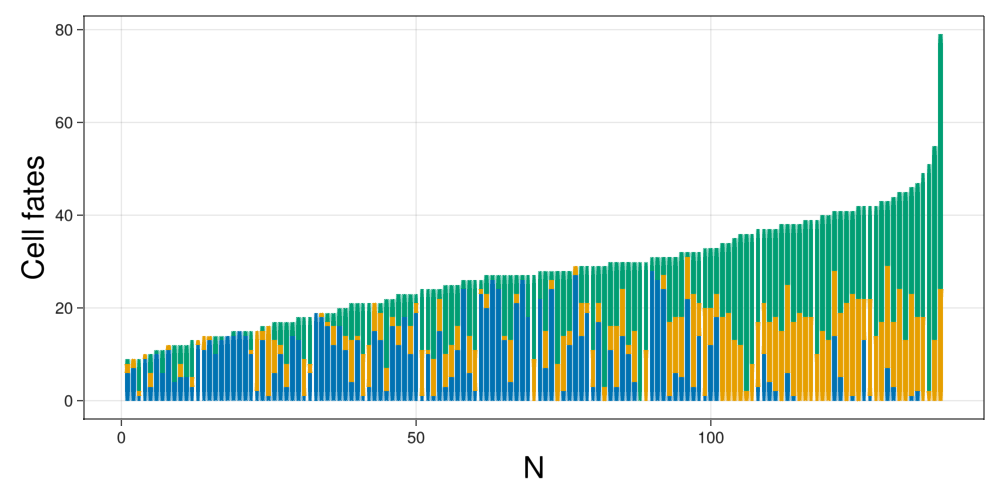

In [18]:
fig = Figure(resolution=(1000,500))

ax = Axis(fig[1,1],xlabel="N",xlabelsize=30,ylabel="Cell fates",ylabelsize=30)

offset = zeros(size(data["DP"])[1])
legend = []
order = sortperm(data["N"])
for cellId in fates
    bp = barplot!(ax,data[cellId][order], offset=offset, color = colorMap[cellId])
    push!(legend,bp)
    offset .+= data[cellId][order]
end

fig

We see that the data corresponds to sets ranging from 5 to 60 cells, being the usual sized between 5 to 30. 

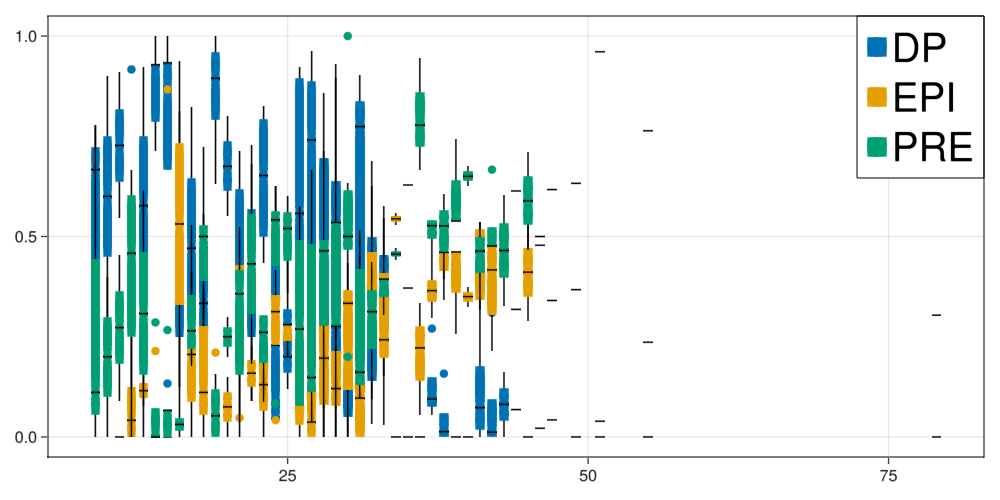

In [19]:
fig = Figure(resolution=(1000,500))
ax = Axis(fig[1,1])
legend = []

cluster = 1
for cellId in fates
    Ngrouped = round.(Int64,data["N"]/cluster).*cluster
    l = boxplot!(ax,Ngrouped,(data[cellId]./data["N"]),label=cellId, color=colorMap[cellId])
    push!(legend,l)
end
Legend(fig[1,1], legend, fates, halign = :right, valign = :top, tellheight = false, tellwidth = false, labelsize=40)

fig

### Set the exploration space

The optimization algorithms require that you specify a set of parameters to optimize. in our case, our parameters correspond to parameters to the agent. However, they does not need to correcpond to parameters of the agent at all. They will be specified for the algorithm to sample from them and give new updates while optimising. 

We have to define them as a dicctionary.

In [20]:
explore = Dict([
            :α=>(0,20),
            :K=>(0,2),
            :nn=>(0,5),
            :mm=>(0,5),
            :nCirc=>(0,30),
            :σNCirc=>(0,20),
            :c0=>(0,20)
        ]);

### Construct loos function

With the data prepared to be compared, we set the loos function. 

The loos function is a function that has to receive at least one argument, a `RowDataframe` object that contains the information of the parameters that are being fitted and has to return a value indicating how good wwere the simulations.

The function is very general so it can fit a many different routines.

Our function basically contains the following steps:

 - Sets the new parameters
 - Run several simulations for that set of parameters to get robust statistics
 - Cluster the results from the simulations as before to compare it to the experimental data
 - Compare the experimental and simulation results using a Chi Square metric as loos value.
 
The specific form of the function will depend on the optimization algorithm at hand.

In [21]:
function loosFunction(params;parameters=parameters,data=data,nRepetitions=1,saveEach=10,dt=0.001)

    #Modify the set of parameters
    parametersModified = copy(parameters)
    parametersModified[:α] = params.α[1]
    parametersModified[:K] = params.K[1]
    parametersModified[:nn] = params.nn[1]
    parametersModified[:mm] = params.mm[1]
    parametersModified[:nCirc] = params.nCirc[1]
    parametersModified[:σNCirc] = params.σNCirc[1]
    parametersModified[:c0] = params.c0[1]
    
    #Make a batch of simulations and get relevant information
    prop = makeStatistics(com,parametersModified,dt,steps,saveEach,nRepetitions);

    #Prepare data for fitting
    p = transpose([prop["DP"] prop["EPI"] prop["PRE"]]./prop["N"])
    
    #Xi square loos
    loos = 0.
    for n in minimum(data["N"]):maximum(data["N"])
        p = prop["N"] .== n
        if sum(p) > 0
            dist = [mean(prop["DP"][p])/n,mean(prop["EPI"][p])/n,mean(prop["PRE"][p])/n]
            for (nn,dp,epi,pre) in zip(data["N"],data["DP"],data["EPI"],data["PRE"])
                if nn == n
                    loos += sum((dist.-[dp,epi,pre]./n).^2)
                end
            end
        end
    end
    #Return loos
    return loos
    
end

loosFunction (generic function with 1 method)

### Check stability of loos function

We run the loos function several times to check that the results are consistent between runs. If the loos function returned different results outside the expected fluctuations, the model would not be proporly fitted as the algorithms would not be able to minimize consistently the cost.

The fluctuations for the simulations using 10 repetitions of the simulation for the same parameters show already enough consistency.

In [22]:
initialisation = DataFrame([:α=>parameters[:α],:K=>parameters[:K],:nn=>parameters[:nn],:mm=>parameters[:mm],:nCirc=>parameters[:nCirc],:σNCirc=>parameters[:σNCirc],:c0=>parameters[:c0]])

Threads.@threads for i in 1:3
    println(loosFunction(initialisation,nRepetitions=1))
end

43.66465425385882
40.19961640416682
39.79395560531394


In [23]:
CBMFitting.swarmAlgorithm(loosFunction,explore,population=10,stopMaxGenerations=10,saveFileName="Optimization",verbose=true)

Generation 1/10 100%|████████████████████████████████████| Time: 0:06:33
Generation 2/10 100%|████████████████████████████████████| Time: 0:06:18
Generation 3/10 100%|████████████████████████████████████| Time: 0:06:29
Generation 4/10 100%|████████████████████████████████████| Time: 0:06:22
Generation 5/10 100%|████████████████████████████████████| Time: 0:06:28
Generation 6/10 100%|████████████████████████████████████| Time: 0:06:35
Generation 7/10 100%|████████████████████████████████████| Time: 0:06:20
Generation 8/10 100%|████████████████████████████████████| Time: 0:06:27
Generation 9/10 100%|████████████████████████████████████| Time: 0:06:41
Generation 10/10 100%|███████████████████████████████████| Time: 0:06:25


Row,α,nn,K,mm,nCirc,σNCirc,c0,α_velocity_,nn_velocity_,K_velocity_,mm_velocity_,nCirc_velocity_,σNCirc_velocity_,c0_velocity_,_score_,_generation_
,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Int64
93,14.9389,1.95144,1.39619,1.42773,12.3225,9.68273,9.7174,-0.0968626,-0.0562549,-0.0105383,0.047756,0.0882151,0.278174,0.0248736,45.7751,10


In [24]:
optimization = CSV.read("Optimization.csv",DataFrame);

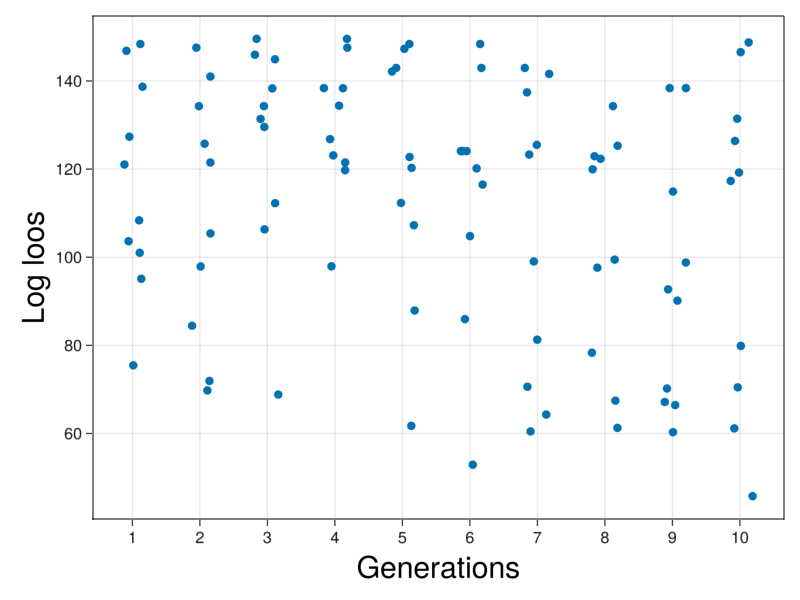

In [25]:
fig = Figure()
ax = Axis(fig[1,1],xticks=1:10,xlabel="Generations",xlabelsize=30,ylabel="Log loos",ylabelsize=30)

scatter!(ax,optimization._generation_.+rand(Uniform(-.2,.2),length(optimization._generation_)),(optimization._score_))
#xticks!(ax,[1,2,3],[1,2,3])

display(fig)

In [26]:
propQualitative = makeStatistics(com,parameters,dt,steps,saveEach,nRepetitions);

In [27]:
params = optimization[argmin(optimization[!,"_score_"]),:]
parametersModified = copy(parameters)
parametersModified[:α] = params.α[1]
parametersModified[:K] = params.K[1]
parametersModified[:nn] = params.nn[1]
parametersModified[:mm] = params.mm[1]
parametersModified[:nCirc] = params.nCirc[1]
parametersModified[:σNCirc] = params.σNCirc[1]

propFitted = makeStatistics(com,parametersModified,dt,steps,saveEach,nRepetitions);

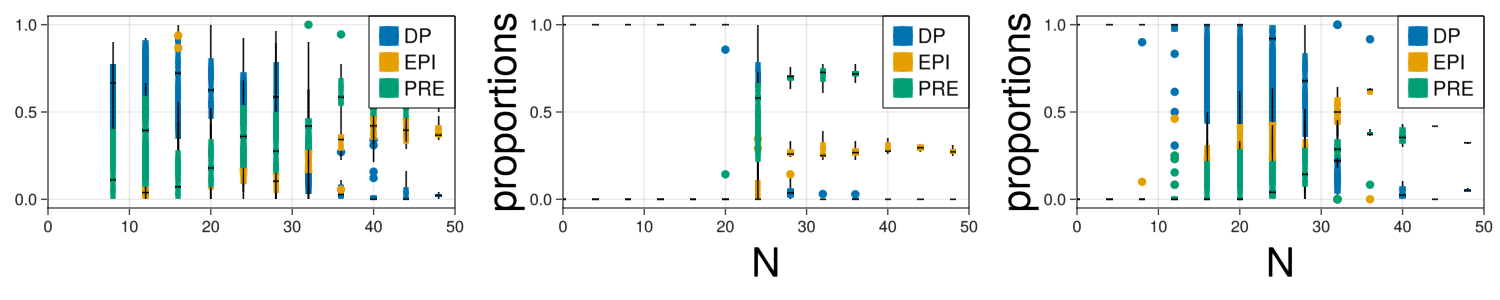

In [28]:
cluster = 4
dt = 0.001
steps = round(Int64,50/dt)
saveEach = round(Int64,1/dt)
nRepetitions = 5

fig = Figure(resolution=(1500,300))

#Real
ax = Axis(fig[1,1])
legend = []
for cellId in fates
    Ngrouped = round.(Int64,data["N"]/cluster).*cluster
    l = boxplot!(ax,Ngrouped,(data[cellId]./data["N"]),label=cellId, color=colorMap[cellId])
    push!(legend,l)
end
xlims!(0,50)
Legend(fig[1,1], legend, fates, halign = :right, valign = :top, tellheight = false, tellwidth = false, labelsize=20)

#Original fit
ax = Axis(fig[1,2],xlabel="N",xlabelsize=40,ylabel="proportions",ylabelsize=40)
legend = []
for i in ["DP","EPI","PRE"]
    Ngrouped = round.(Int64,propQualitative["N"]/cluster).*cluster
    l = boxplot!(ax,Ngrouped,propQualitative[i]./propQualitative["N"],color=colorMap[i])
    push!(legend,l)
end
xlims!(0,50)
Legend(fig[1,2], legend, ["DP","EPI","PRE"], halign = :right, valign = :top, tellheight = false, tellwidth = false, labelsize=20)

#Swarm fit
ax = Axis(fig[1,3],xlabel="N",xlabelsize=40,ylabel="proportions",ylabelsize=40)
legend = []
for i in ["DP","EPI","PRE"]
    Ngrouped = round.(Int64,propFitted["N"]/cluster).*cluster
    l = boxplot!(ax,Ngrouped,propFitted[i]./propFitted["N"],color=colorMap[i])
    push!(legend,l)
end
xlims!(0,50)
Legend(fig[1,3], legend, ["DP","EPI","PRE"], halign = :right, valign = :top, tellheight = false, tellwidth = false, labelsize=20)

display(fig)